## Instals and Imports

In [1]:
%%capture
# !pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0
!pip install pytorch_lightning==2.1
!pip install pandas librosa opencv-python matplotlib  #cupy-cuda110 
!pip install -U albumentations

In [1]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import WeightedRandomSampler
        

## Kaggle Score 

In [2]:
class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype  for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return sklearn.metrics.roc_auc_score(solution[scored_columns].values, submission[scored_columns].values, average='macro')

## Configuration

In [25]:
class CONFIG:
    
    # == GENERAL ==
    seed = 13                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/rgbimgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/effnet_3fold_rgb'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 40                           # min frequency
    max_freq = 15000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 3                               # n fold
    epochs = 5                              # max epochs
    lr = 1e-3                               # learning rate
    weight_decay = 1e-5                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device, ', Using', torch.cuda.device_count(), 'GPU(s)')
pl.seed_everything(CONFIG.seed, workers=True)

Seed set to 13


Device: cuda:0 , Using 1 GPU(s)


13

## Preprocessing

Input: train_metadata.csv

Output: Folder com as os espectrogramas na forma de imagem.

In [27]:
df = pd.read_csv(f'{CONFIG.data_dir_2024}/train_metadata.csv')
df.head()

# Labels
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['primary_label', 'rating', 'filename']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.primary_label.map(label2id)

# Create Filepath
train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [44]:
def opposite_melspectrogram(data):
    n_fft = CONFIG.n_fft
    hop_length = CONFIG.hop_len
    rate = CONFIG.sr
    n_mels = 128

    mel_frequencies = librosa.mel_frequencies(n_mels=128)
    
    # Inverter as janelas mel para que as frequências mais altas tenham janelas mais curtas
    mel_window = librosa.filters.mel(sr= rate, n_fft = n_fft, n_mels=n_mels, htk=True)
    
    # Inverter a ordem das janelas
    mel_window = mel_window[:, ::-1]
    
    # Calcular o espectrograma mel com a escala mel customizada
    S = np.dot(mel_window, np.log(np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))**2 + 1e-20))

    spec_data = librosa.amplitude_to_db(S, ref=np.max)

    return spec_data

def preprocess_fn(filepath, side = 'center'):

    # LOAD .OGG
    audio_data, _ = librosa.load(filepath, sr=CONFIG.sr)

    if(side == 'center'):
        # CROP CENTER 5 SECONDS,  OR COPY N_COPY TIMES IF <5s (UNTIL 5s is achieved)
        n_copy = math.ceil(5 * CONFIG.sr / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)
        start_idx = int(len(audio_data) / 2 - 2.5 * CONFIG.sr)
        end_idx = int(start_idx + 5.0 * CONFIG.sr)
        input_audio = audio_data[start_idx:end_idx]
    elif(side == 'left'):
        # CROP FIRST 5 SECONDS,  OR COPY N_COPY TIMES IF <5s (UNTIL 5s is achieved)
        n_copy = math.ceil(5 * CONFIG.sr / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)
        start_idx = 0
        end_idx = int(5.0 * CONFIG.sr)
        input_audio = audio_data[start_idx:end_idx]
    elif(side == 'right'):
        # CROP LAST 5 SECONDS,  OR COPY N_COPY TIMES IF <5s (UNTIL 5s is achieved)
        n_copy = math.ceil(5 * CONFIG.sr / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)
        start_idx = int(-5.0 * CONFIG.sr)
        input_audio = audio_data[start_idx:]

    # HANDLE NaNs
    mean_signal = np.nanmean(input_audio)
    input_audio = np.nan_to_num(input_audio, nan=mean_signal) if np.isnan(input_audio).mean() < 1 else np.zeros_like(input_audio)
    
    # SPECTROGRAM
    frequencies, times, spec_data = sci_signal.spectrogram(
        input_audio, 
        fs=CONFIG.sr, 
        nfft=CONFIG.n_fft, 
        nperseg=CONFIG.win_len, 
        noverlap=CONFIG.hop_len, 
        window='hann'
    )
    
    # FILTER LOWER AND HIGHER FREQUENCIES
    valid_freq = (frequencies >= CONFIG.min_freq) & (frequencies <= CONFIG.max_freq)
    spec_data = spec_data[valid_freq, :]
    
    # COMPUTE LOG SPEC
    R = np.log10(spec_data + 1e-20)
    # MIN/MAX NORMALIZATION
    R = R - R.min()
    R = R / R.max()

    sg = librosa.feature.melspectrogram(
            y=input_audio,
            sr=CONFIG.sr,
            n_fft=CONFIG.n_fft,
            win_length=CONFIG.win_len,
            hop_length=CONFIG.hop_len,
            n_mels=128,
            fmin=CONFIG.min_freq,
            fmax=CONFIG.max_freq,
            power=1,
        )
    G = librosa.amplitude_to_db(sg, ref=np.max)
    # MIN/MAX NORMALIZATION
    G = G - G.min()
    G = G / G.max()

    B = opposite_melspectrogram(input_audio)
    # MIN/MAX NORMALIZATION
    B = B - B.min()
    B = B / B.max()

    # SPEC TO IMAGE
    R = cv2.resize(R, (256, 256), interpolation=cv2.INTER_AREA)
    G = cv2.resize(G, (256, 256), interpolation=cv2.INTER_AREA)
    B = cv2.resize(B, (256, 256), interpolation=cv2.INTER_AREA)
    
    return np.array([R,G,B]).transpose(1,2,0) # (256,256,3)

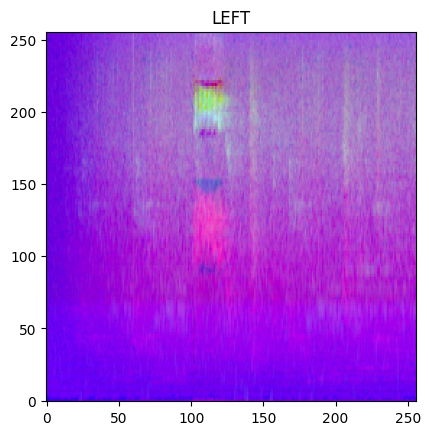

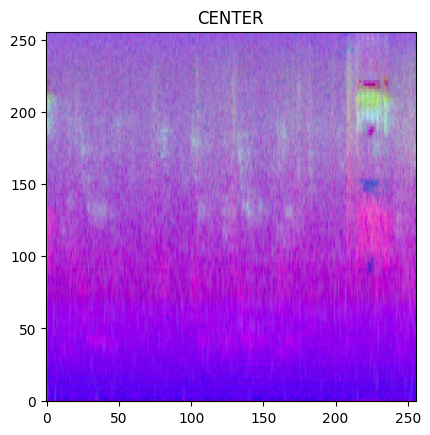

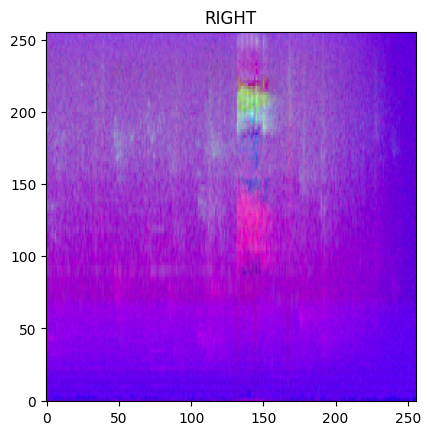

In [45]:
# Just testing

processed_spec_left = preprocess_fn(train_df['filepath'].values[0], side = 'left')
processed_spec_center = preprocess_fn(train_df['filepath'].values[0], side = 'center')
processed_spec_right = preprocess_fn(train_df['filepath'].values[0], side = 'right')

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [46]:
if not CONFIG.preprocess:
    all_bird_data = np.load(f'{CONFIG.preprocessed_data}/spec_center_5sec_256_256.npy', allow_pickle=True).item()
else:
    all_bird_data = dict()
    for i, row_metadata in tqdm(train_df.iterrows()):
        
        # filepath to processed spec img center, left and right
        processed_spec = preprocess_fn(row_metadata.filepath, side = 'center')
        all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

        processed_spec = preprocess_fn(row_metadata.filepath, side = 'left')
        all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)

        processed_spec = preprocess_fn(row_metadata.filepath, side = 'right')
        all_bird_data[row_metadata.name] = processed_spec.astype(np.float32)
    
    # save to file
    np.save(os.path.join(CONFIG.preprocessed_data, f'spec_3sides_5sec_256_256.npy'), all_bird_data)

868it [09:20,  1.55it/s]


KeyboardInterrupt: 

In [ ]:
len(all_bird_data)

## Dataset

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        metadata,
        augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.metadata = metadata
        self.augmentation = augmentation
        self.mode = mode
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        row_metadata = self.metadata.iloc[index]
        
        # load spec. data
        input_spec = all_bird_data[row_metadata.name]
        
        # aug
        if self.augmentation is not None:
            input_spec = self.augmentation(image=input_spec)['image']
        
        # target
        target = row_metadata.target
        
        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

In [ ]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 3),
                num_masks_y=(1, 3),
                mask_x_length=(1, 10),
                mask_y_length=(1, 20),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [ ]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img)
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
dummy_dataset = BirdDataset(train_df, get_transforms('train'))

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()


## Cross-Validation

In [ ]:
kf = KFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.seed)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(train_idx[:4])
    # train_df.loc[val_idx, 'fold'] = fold
    break

# Somente uma forma de poder splittar em N folds mantendo uma proporção de test_size
## Dados que se utilizar o KFold com 3 splits, ele vai dividir necessariamente em 66% train 33% test
## Dessa forma conseguimos fazer 3 splits, onde necessariamente temos seila 90% train 10% test
## O ponto negativo é que não há garantia de não sobreposição de treino/test, o que pode interferir principalmente em:
## - Qualidade da validação interna
## - Melhoras durante o ensemble dos N modelos (dado que agora temos menos variação entre os folds)
## Melhorias a fazer são:
## - Garantir splits com conjuntos mais diferentes possíveis
## - Modelar de formas diferentes cada fold (modelos diferentes, balanceamentos diferentes, dados diferentes)
def train_test_indices(data, labels, test_size=0.2, random_state=None):
    # Dividir os dados em conjunto de treino e teste mantendo a estratificação dos rótulos
    train_idx, val_idx = train_test_split(np.arange(len(data)), test_size=test_size, random_state=random_state, stratify=labels)

    return train_idx, val_idx

train_idx, val_idx = train_test_indices(train_df, train_df['target'], test_size=0.1, random_state=42)
print(train_idx[:4])

In [ ]:
# Agora que validamos que os indices saem no formato semelhante vamos ajustar criando N_colunas, com 1 para treino e 0 teste

for i in range(3): # 3 folds
    train_df[f'fold{i}'] = 0 ## Todos são zero
    train_idx, val_idx = train_test_indices(train_df, train_df['target'], test_size=0.2, random_state=42)
    train_df.loc[train_idx, f'fold{i}'] = 1 ## Onde for treino vira 1

## Model

In [ ]:
class EffNet(nn.Module):
    
    def __init__(self, model_type, n_classes, pretrained=True):
        super().__init__()
        
        if model_type == 'efficientnet_b0':
            if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b0(weights=weights)
        elif model_type == 'efficientnet_b1':
            if pretrained: weights = efficientnet.EfficientNet_B1_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b1(weights=weights)
        elif model_type == 'efficientnet_b2':
            if pretrained: weights = efficientnet.EfficientNet_B2_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b2(weights=weights)
        elif model_type == 'efficientnet_b3':
            if pretrained: weights = efficientnet.EfficientNet_B3_Weights.DEFAULT
            else: weights = None
            self.base_model = efficientnet.efficientnet_b3(weights=weights)
        else:
            raise ValueError('model type not supported')
        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
    def forward(self, x):
        # x = x.unsqueeze(-1)
        # x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
        x = x.permute(0,3,1,2)
        return self.base_model(x)

In [ ]:
dummy_model = EffNet(CONFIG.model, n_classes=len(label_list))

dummy_input = torch.randn(2, 256, 256, 3)
print(dummy_model(dummy_input).shape)


## Lightning Module

In [ ]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(CONFIG.model, n_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=CONFIG.lr,
            weight_decay=CONFIG.weight_decay
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=CONFIG.epochs,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

## Training Loop

In [ ]:
def predict(data_loader, model):
    model.to(CONFIG.device)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [ ]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df[f'fold{fold_id}'] == 1].copy()
    valid_df = total_df[total_df[f'fold{fold_id}'] == 0].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')

    # == create a sampler that samples inversely of its counts ==
    y_train = train_df['target']
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    
    
    train_ds = BirdDataset(train_df, get_transforms('train'), 'train')
    val_ds = BirdDataset(valid_df, get_transforms('valid'), 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
        sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size * 2,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=CONFIG.checkpoint_dir,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=CONFIG.epochs,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if CONFIG.mix_precision else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{CONFIG.checkpoint_dir}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

## RUN

In [ ]:
# training
torch.set_float32_matmul_precision('high')

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(CONFIG.folds):
    
    # get validation index
    val_idx = list(train_df[train_df[f'fold{f}'] == 0].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{CONFIG.checkpoint_dir}/oof_pred.csv", index=False)